# EE 595 Final Project

## Preamble and other sundry items

In [2]:
import os
import time as tm
import datetime as dt
import random

# Data preparation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from collections import deque
import sqlalchemy as sa
from huggingface_hub import hf_hub_download
from datasets import load_dataset

# AI
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv()

True

## Load the data

In [5]:
REPO_ID = "johnrizzo1/stocks_daily_price"
ds = load_dataset(REPO_ID)
training_set = ds['train']
init_df = training_set.to_pandas()

In [6]:
print("DataFrame shape:", init_df.shape)
print("\nDataFrame info:")
print(init_df.info())
print("\nFirst few rows:")
print(init_df.head())

DataFrame shape: (24239949, 8)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24239949 entries, 0 to 24239948
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   symbol     object 
 1   date       object 
 2   open       float64
 3   high       float64
 4   low        float64
 5   close      float64
 6   volume     int64  
 7   adj_close  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.4+ GB
None

First few rows:
  symbol        date       open       high        low      close    volume  \
0      A  1999-11-18  32.546494  35.765381  28.612303  31.473534  62546380   
1      A  1999-11-19  30.713518  30.758226  28.478184  28.880545  15234146   
2      A  1999-11-22  29.551144  31.473534  28.657009  31.473534   6577870   
3      A  1999-11-23  30.400572  31.205294  28.612303  28.612303   5975611   
4      A  1999-11-24  28.701717  29.998213  28.612303  29.372318   4843231   

   adj_close  
0  26.455530  
1  24.275963  


This is a lot of data.  For our purposes we can reduce this to a single company such as Apple (APPL) or Ford (F).  We will also limit this to three year's worth of data.

In [23]:
filtered_df = init_df[init_df['symbol'] == 'F']
filtered_df = filtered_df[filtered_df['date'] >= '2010-01-01']
filtered_df = filtered_df[filtered_df['date'] <= '2012-12-31']

In [24]:
print(filtered_df.shape)

(754, 8)


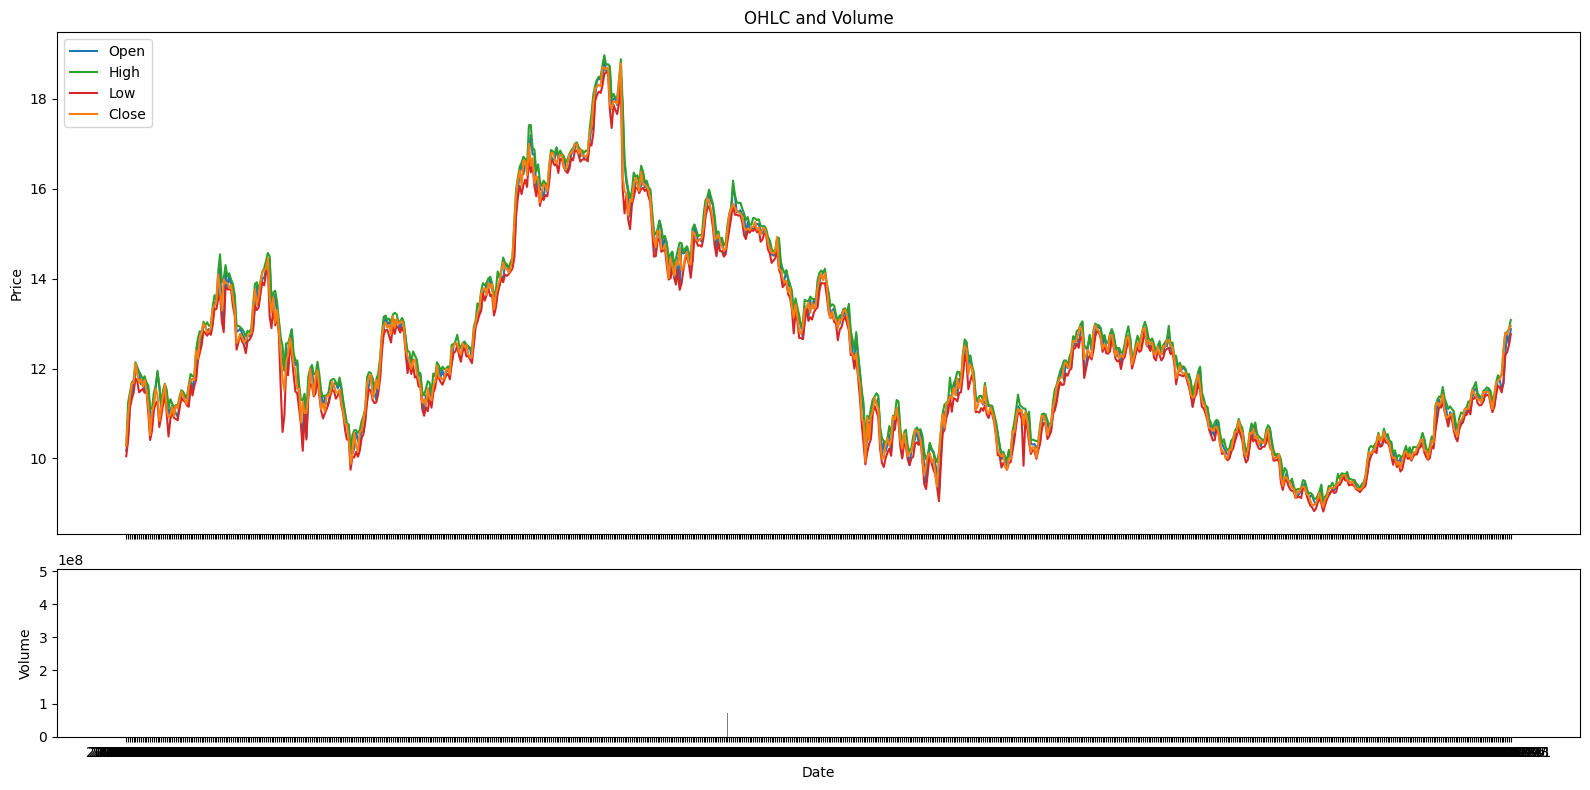

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot OHLC
ax1.plot(filtered_df.date, filtered_df['open'], label='Open', color='tab:blue')
ax1.plot(filtered_df.date, filtered_df['high'], label='High', color='tab:green')
ax1.plot(filtered_df.date, filtered_df['low'], label='Low', color='tab:red')
ax1.plot(filtered_df.date, filtered_df['close'], label='Close', color='tab:orange')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.set_title('OHLC and Volume')

# Plot Volume
ax2.bar(filtered_df.date, filtered_df['volume'], width=0.0005, color='tab:gray')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

You can see that there is one value skewing the volume.  I took out the top and bottom outliers and it looked much better.  I verified the data and it looks correct.  The outlier is likely a black swan scenario so I have left it in.  

## Prepare the data

In [27]:
# From this point forward init_df is the new name for filtered_df
init_df = filtered_df

# Scale the data
scaler = MinMaxScaler()
init_df['open'] = scaler.fit_transform(init_df[['open']])
init_df['high'] = scaler.fit_transform(init_df[['high']])
init_df['low'] = scaler.fit_transform(init_df[['low']])
init_df['close'] = scaler.fit_transform(init_df[['close']])
init_df['volume'] = scaler.fit_transform(init_df[['volume']])
init_df.head()

,symbol,date,open,high,low,close,volume,adj_close
7876115,F,2010-01-04,0.120163,0.125755,0.125638,0.137791,0.096427,5.420370
7876116,F,2010-01-05,0.148676,0.222334,0.161389,0.206687,0.429363,5.778914
7876117,F,2010-01-06,0.226069,0.244467,0.235955,0.248227,0.395912,5.995096
7876118,F,2010-01-07,0.251528,0.267606,0.255363,0.277609,0.245606,6.148005
7876119,F,2010-01-08,0.272912,0.272636,0.269663,0.280648,0.246169,6.163823


### Helper Functions

In [28]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [29]:
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd - signal

In [30]:
def compute_stochastic_oscillator(series, window=14):
    high = series.rolling(window=window).max()
    low = series.rolling(window=window).min()
    return 100 * (series - low) / (high - low)

In [31]:

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

In [32]:
def compute_ema(series, window=12):
    return series.ewm(span=window, adjust=False).mean()

In [33]:
def compute_sma(series, window=12):
    return series.rolling(window=window).mean()

In [ ]:
def adjust_for_volatility(current_volatility, base_volatility, stop_loss_pct, take_profit_pct):
    """
    Adjust stop-loss and take-profit levels based on current market volatility.

    Args:
        current_volatility (float): The current market volatility.
        base_volatility (float): The base volatility for comparison.
        stop_loss_pct (float): The base stop-loss percentage threshold.
        take_profit_pct (float): The base take-profit percentage threshold.

    Returns:
        tuple: Adjusted stop-loss and take-profit percentages.
    """
    volatility_factor = current_volatility / base_volatility
    adjusted_stop_loss_pct = stop_loss_pct * volatility_factor
    adjusted_take_profit_pct = take_profit_pct * volatility_factor
    return adjusted_stop_loss_pct, adjusted_take_profit_pct


In [51]:
def apply_risk_management(predicted_price, current_price, stop_loss_pct=0.02, take_profit_pct=0.05):
    """
    Apply risk management strategies by simulating stop-loss and take-profit levels.

    Args:
        predicted_price (float): The predicted price of the asset.
        current_price (float): The current price of the asset.
        stop_loss_pct (float): The stop-loss percentage threshold.
        take_profit_pct (float): The take-profit percentage threshold.

    Returns:
        str: The action to take ('hold', 'sell', or 'buy').
    """
    stop_loss_price = current_price * (1 - stop_loss_pct)
    take_profit_price = current_price * (1 + take_profit_pct)

    if predicted_price <= stop_loss_price:
        return 'sell'
    elif predicted_price >= take_profit_price:
        return 'buy'
    else:
        return 'hold'


In [52]:
def calculate_position_size(account_balance, risk_per_trade, stop_loss_pct):
    """
    Calculate the position size based on account balance and risk per trade.

    Args:
        account_balance (float): The total account balance.
        risk_per_trade (float): The percentage of the account balance to risk per trade.
        stop_loss_pct (float): The stop-loss percentage threshold.

    Returns:
        float: The position size.
    """
    risk_amount = account_balance * risk_per_trade
    position_size = risk_amount / stop_loss_pct
    return position_size


### Prepare the data for training the model

In [43]:
def PrepareData(init_df, steps=1):
    """Prepare the data for training the model.
    
    Args:
        df (pd.DataFrame): The initial DataFrame containing the data.
        steps (int): The number of steps to look ahead for the future price.
    
    Returns:
        pd.DataFrame: The prepared DataFrame with the future price and technical indicators.
    """
    df = init_df.copy()

    # Scope the data to what we really need
    df.index = pd.to_datetime(df.index)
    # df.drop(columns=['rtype', 'publisher_id', 'instrument_id', 'symbol'], inplace=True)
    df.drop(columns=['symbol'], inplace=True)

    # Calculate the IQR and remove volume outliers
    sf_quantile = df['volume'].quantile(0.75)
    tf_quantile = df['volume'].quantile(0.25)
    iqr = sf_quantile - tf_quantile
    upper_bound = sf_quantile + 1.5 * iqr
    lower_bound = tf_quantile - 1.5 * iqr
    df = df[(df['volume'] < upper_bound) & (df['volume'] > lower_bound)]

    # Reset index to make datetime a column if needed for processing
    if 'date' not in df.columns:
        df.reset_index(inplace=True)
        df.rename(columns={'datetime': 'date'}, inplace=True)

    df['future'] = df['close'].shift(-steps)

    # Add technical indicators
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma15'] = df['close'].rolling(window=15).mean()
    df['rsi'] = compute_rsi(df['close'], window=14)
    df['macd'] = compute_macd(df['close'])

    # Fill NaN values that may be created by technical indicators
    df = df.bfill().ffill()

    # Setup Feature Columns
    feature_columns = ['open', 'high', 'low', 'close', 'volume', 'ma5', 'ma15', 'rsi', 'macd']

    # Ensure all feature columns are float type
    for col in feature_columns:
        df[col] = df[col].astype(np.float32)

    # Create feature matrix
    features = df[feature_columns].values

    # Get the last N_STEPS + days for last_sequence
    last_data = features[-N_STEPS-steps:]

    # Create sequences for training
    sequence_data = []

    for i in range(len(df) - N_STEPS - steps + 1):
        seq = features[i:i+N_STEPS]
        if len(seq) == N_STEPS:
            target = df['future'].iloc[i+N_STEPS-1]
            sequence_data.append([seq, target])

    # Prepare last sequence for prediction
    last_sequence = last_data[:N_STEPS]

    # Construct X and y arrays
    X = np.array([seq for seq, _ in sequence_data], dtype=np.float32)
    y = np.array([target for _, target in sequence_data], dtype=np.float32)

    return df, last_sequence, X, y

## Get the trained model

In [35]:
def GetTrainedModel(x_train, y_train, batch_size, epochs, lstm_units):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(N_STEPS, x_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(lstm_units * 2, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    checkpoint_path = "F1.weights.h5"
    full_model_path = "F1.model.keras"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[cp_callback, es_callback],
              verbose="1")

    model.summary()
    model.save(full_model_path)

    return model

## Get the best parameters using Random Search

In [ ]:
# SETTINGS
N_STEPS = 10  # Window size or the sequence length, 7 (1 week)
LOOKUP_STEPS = [1, 2, 3]  # Lookup steps, 1 is the next day, 3 = after tomorrow
predictions = []

In [37]:
def random_search(x_train, y_train, num_iterations=10):
    best_loss = float('inf')
    best_params = None

    for _ in range(num_iterations):
        batch_size = random.choice([8, 16, 32])
        epochs = random.choice([50, 100, 150])
        lstm_units = random.choice([50, 100, 150])

        print(f"Trying batch_size={batch_size}, epochs={epochs}, lstm_units={lstm_units}")
        model = GetTrainedModel(x_train, y_train, batch_size, epochs, lstm_units)
        loss = model.evaluate(x_train, y_train, verbose=0)

        if loss < best_loss:
            best_loss = loss
            best_params = (batch_size, epochs, lstm_units)

    print(f"Best params: batch_size={best_params[0]}, epochs={best_params[1]}, lstm_units={best_params[2]} with loss={best_loss}")
    return best_params

In [44]:
for step in LOOKUP_STEPS:
    print(f"\nPreparing data for {step}-step prediction...")
    df, last_sequence, x_train, y_train = PrepareData(init_df, step)
                
    print(f"Training data shape: X={x_train.shape}, Y={y_train.shape}")
                
    print(f"\nPerforming random search for optimal parameters...")
    best_params = random_search(x_train, y_train)
                
    print(f"\nTraining model with best parameters...")
    # model = GetTrainedModel(x_train, y_train, 8, 50, 50)
    model = GetTrainedModel(x_train, y_train, *best_params)
                
    print(f"\nMaking prediction...")
    prediction = model.predict(np.expand_dims(last_sequence, axis=0))
    predicted_price = scaler.inverse_transform(prediction)[0][0]
                
    predictions.append(round(float(predicted_price), 2))
    print(f"Predicted price for {step} step(s) ahead: ${predicted_price:.2f}")



Preparing data for 1-step prediction...
Training data shape: X=(692, 10, 9), Y=(692,)

Performing random search for optimal parameters...
Trying batch_size=32, epochs=150, lstm_units=100
Epoch 1/150


/Users/jrizzo/Projects/courses/EE595/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.h5
Epoch 19/150

Epoch 19: saving model to F1.weights.h5
Epoc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=32, epochs=50, lstm_units=150
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=150, lstm_units=150
Epoch 1/150

Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=150, lstm_units=150
Epoch 1/150

Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=8, epochs=100, lstm_units=100
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.h

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=32, epochs=100, lstm_units=100
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=8, epochs=100, lstm_units=50
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.h5

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=16, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=8, epochs=50, lstm_units=150
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epoc

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Best params: batch_size=8, epochs=50, lstm_units=150 with loss=0.0013819357845932245

Training model with best parameters...
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.wei

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)


Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted price for 1 step(s) ahead: $0.37

Preparing data for 2-step prediction...
Training data shape: X=(691, 10, 9), Y=(691,)

Performing random search for optimal parameters...
Trying batch_size=32, epochs=150, lstm_units=50
Epoch 1/150


/Users/jrizzo/Projects/courses/EE595/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.h5
Epoch 19/150

Epoch 19: saving model to F1.weights.h5
Epoc

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=8, epochs=50, lstm_units=50
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epoch

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=32, epochs=50, lstm_units=150
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epo

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 13: early stopping


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=100, lstm_units=100
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=8, epochs=100, lstm_units=50
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 17: early stopping


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=8, epochs=50, lstm_units=100
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epoc

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=8, epochs=100, lstm_units=50
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.h5

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=16, epochs=100, lstm_units=100
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=32, epochs=150, lstm_units=150
Epoch 1/150

Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Best params: batch_size=16, epochs=100, lstm_units=100 with loss=0.002314887708052993

Training model with best parameters...
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: savi

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)


Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted price for 2 step(s) ahead: $0.32

Preparing data for 3-step prediction...
Training data shape: X=(690, 10, 9), Y=(690,)

Performing random search for optimal parameters...
Trying batch_size=16, epochs=150, lstm_units=150
Epoch 1/150


/Users/jrizzo/Projects/courses/EE595/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.h5
Epoch 19/150

Epoch 19: saving model to F1.weights.h5
Epoc

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=8, epochs=50, lstm_units=100
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epoc

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=16, epochs=100, lstm_units=50
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.h

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=16, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=50, lstm_units=50
Epoch 1/50

Epoch 1: saving model to F1.weights.h5
Epoch 2/50

Epoch 2: saving model to F1.weights.h5
Epoch 3/50

Epoch 3: saving model to F1.weights.h5
Epoch 4/50

Epoch 4: saving model to F1.weights.h5
Epoch 5/50

Epoch 5: saving model to F1.weights.h5
Epoch 6/50

Epoch 6: saving model to F1.weights.h5
Epoch 7/50

Epoch 7: saving model to F1.weights.h5
Epoch 8/50

Epoch 8: saving model to F1.weights.h5
Epoch 9/50

Epoch 9: saving model to F1.weights.h5
Epoch 10/50

Epoch 10: saving model to F1.weights.h5
Epoch 11/50

Epoch 11: saving model to F1.weights.h5
Epoch 12/50

Epoch 12: saving model to F1.weights.h5
Epoch 13/50

Epoch 13: saving model to F1.weights.h5
Epoch 14/50

Epoch 14: saving model to F1.weights.h5
Epoch 15/50

Epoch 15: saving model to F1.weights.h5
Epoch 16/50

Epoch 16: saving model to F1.weights.h5
Epoch 17/50

Epoch 17: saving model to F1.weights.h5
Epoch 18/50

Epoch 18: saving model to F1.weights.h5
Epoch 19/50

Epoc

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=32, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=32, epochs=150, lstm_units=50
Epoch 1/150

Epoch 1: saving model to F1.weights.h5
Epoch 2/150

Epoch 2: saving model to F1.weights.h5
Epoch 3/150

Epoch 3: saving model to F1.weights.h5
Epoch 4/150

Epoch 4: saving model to F1.weights.h5
Epoch 5/150

Epoch 5: saving model to F1.weights.h5
Epoch 6/150

Epoch 6: saving model to F1.weights.h5
Epoch 7/150

Epoch 7: saving model to F1.weights.h5
Epoch 8/150

Epoch 8: saving model to F1.weights.h5
Epoch 9/150

Epoch 9: saving model to F1.weights.h5
Epoch 10/150

Epoch 10: saving model to F1.weights.h5
Epoch 11/150

Epoch 11: saving model to F1.weights.h5
Epoch 12/150

Epoch 12: saving model to F1.weights.h5
Epoch 13/150

Epoch 13: saving model to F1.weights.h5
Epoch 14/150

Epoch 14: saving model to F1.weights.h5
Epoch 15/150

Epoch 15: saving model to F1.weights.h5
Epoch 16/150

Epoch 16: saving model to F1.weights.h5
Epoch 17/150

Epoch 17: saving model to F1.weights.h5
Epoch 18/150

Epoch 18: saving model to F1.weights.h

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Trying batch_size=32, epochs=100, lstm_units=150
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)

Trying batch_size=16, epochs=100, lstm_units=100
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 10, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 10, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,725 (4.66 MB)

 Trainable params: 407,241 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,484 (3.11 MB)

Trying batch_size=16, epochs=100, lstm_units=50
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: saving model to F1.weights.h5
Epoch 18/100

Epoch 18: saving model to F1.weights.h

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_93 (LSTM)                  │ (None, 10, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,925 (1.19 MB)

 Trainable params: 103,641 (404.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,284 (809.71 KB)

Best params: batch_size=32, epochs=100, lstm_units=150 with loss=0.0034859946463257074

Training model with best parameters...
Epoch 1/100

Epoch 1: saving model to F1.weights.h5
Epoch 2/100

Epoch 2: saving model to F1.weights.h5
Epoch 3/100

Epoch 3: saving model to F1.weights.h5
Epoch 4/100

Epoch 4: saving model to F1.weights.h5
Epoch 5/100

Epoch 5: saving model to F1.weights.h5
Epoch 6/100

Epoch 6: saving model to F1.weights.h5
Epoch 7/100

Epoch 7: saving model to F1.weights.h5
Epoch 8/100

Epoch 8: saving model to F1.weights.h5
Epoch 9/100

Epoch 9: saving model to F1.weights.h5
Epoch 10/100

Epoch 10: saving model to F1.weights.h5
Epoch 11/100

Epoch 11: saving model to F1.weights.h5
Epoch 12/100

Epoch 12: saving model to F1.weights.h5
Epoch 13/100

Epoch 13: saving model to F1.weights.h5
Epoch 14/100

Epoch 14: saving model to F1.weights.h5
Epoch 15/100

Epoch 15: saving model to F1.weights.h5
Epoch 16/100

Epoch 16: saving model to F1.weights.h5
Epoch 17/100

Epoch 17: sav

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_96 (LSTM)                  │ (None, 10, 150)        │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ (None, 10, 300)        │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 20)             │         3,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,525 (10.42 MB)

 Trainable params: 910,841 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,684 (6.95 MB)


Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted price for 3 step(s) ahead: $0.31


In [54]:
# Save the model trained with the best parameters
model.save("F1_best_model.keras")

Best params: batch_size=32, epochs=100, lstm_units=150 with loss=0.0034859946463257074

In [53]:

if predictions:
    predictions_list = [str(d)+'$' for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'\nPrediction for upcoming {len(LOOKUP_STEPS)} steps ({predictions_str})'
    print(message)

    # Risk management and position sizing
    current_price = init_df['close'].iloc[-1]
    print(f"\nCurrent price: ${current_price:.2f}")
                
    account_balance = 10000
    risk_per_trade = 0.01
    base_volatility = 0.02

    current_volatility = init_df['close'].rolling(window=20).std().iloc[-1]
    adjusted_stop_loss_pct, adjusted_take_profit_pct = adjust_for_volatility(
        current_volatility, base_volatility, 0.02, 0.05
    )

    print("\nRisk Management Analysis:")
    print(f"Account Balance: ${account_balance:.2f}")
    print(f"Risk per trade: {risk_per_trade*100}%")
    print(f"Current Volatility: {current_volatility:.4f}")
    print(f"Adjusted Stop Loss: {adjusted_stop_loss_pct*100:.2f}%")
    print(f"Adjusted Take Profit: {adjusted_take_profit_pct*100:.2f}%")

    for i, predicted_price in enumerate(predictions, 1):
        position_size = calculate_position_size(account_balance, risk_per_trade, adjusted_stop_loss_pct)
        action = apply_risk_management(predicted_price, current_price, adjusted_stop_loss_pct, adjusted_take_profit_pct)
        print(f"\nDay {i} Analysis:")
        print(f"Predicted price: ${predicted_price:.2f}")
        print(f"Recommended action: {action.upper()}")
        print(f"Suggested position size: ${position_size:.2f}")


Prediction for upcoming 3 steps (0.37$, 0.32$, 0.31$)

Current price: $0.41

Risk Management Analysis:
Account Balance: $10000.00
Risk per trade: 1.0%
Current Volatility: 0.0617
Adjusted Stop Loss: 6.17%
Adjusted Take Profit: 15.43%

Day 1 Analysis:
Predicted price: $0.37
Recommended action: SELL
Suggested position size: $1619.95

Day 2 Analysis:
Predicted price: $0.32
Recommended action: SELL
Suggested position size: $1619.95

Day 3 Analysis:
Predicted price: $0.31
Recommended action: SELL
Suggested position size: $1619.95


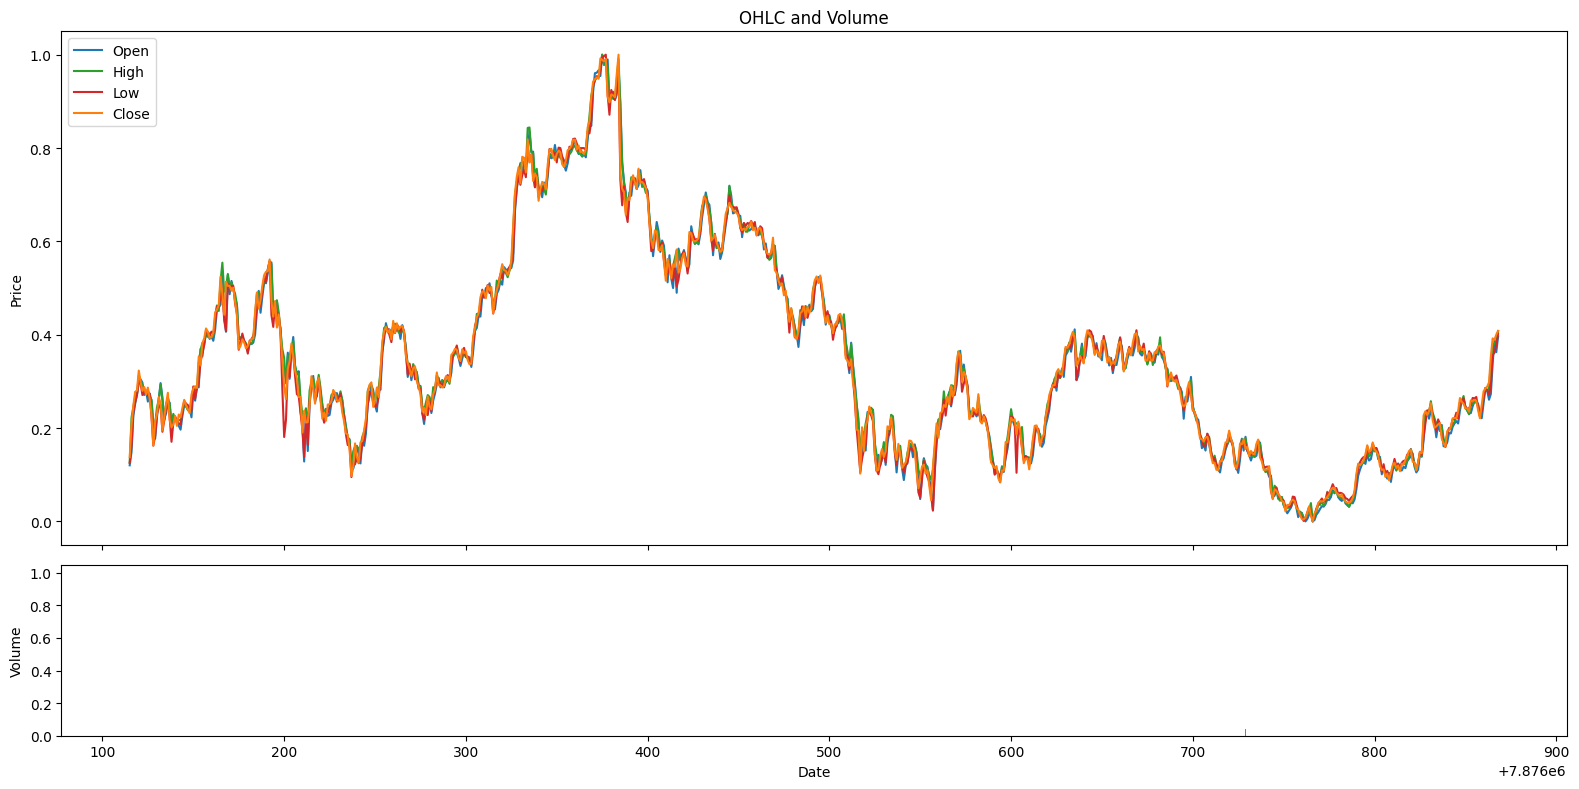

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot OHLC
ax1.plot(init_df.index, init_df['open'], label='Open', color='tab:blue')
ax1.plot(init_df.index, init_df['high'], label='High', color='tab:green')
ax1.plot(init_df.index, init_df['low'], label='Low', color='tab:red')
ax1.plot(init_df.index, init_df['close'], label='Close', color='tab:orange')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.set_title('OHLC and Volume')

# Plot Volume
ax2.bar(init_df.index, init_df['volume'], width=0.0005, color='tab:gray')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()